## DTSA5511: Introduction to Deep Learning

### Final Project: Classifiying Emotions Using RNN

**Overview**

Emotion detection and sentiment analysis are large parts of Natural Language Processing, where the goal is to build models that are able to detect the emotion or polarity of text. This is important due to the nuances within spoken/written language; many words have multiple meanings, so the task is inherently contextual.

Many use cases exist for emotional classification - it could be market researchers that are trying to understand the impact of a product launch, or it could be used to help predict mental health emergencies based upon a patient's speech.

**Project Goal**

The source data is the Kaggle dataset [Emotions Dataset for NLP](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp), and the goal of this project will be to classify the emotions described within a snippet of text. Natural language processing is first performed, then a Recurrent Neural Network (RNN) is used to classify each text string. RNNs are better suited for text classification than standard multi-layer perceptrons, because they factor in results from previous items in a sequence, which allows the model greater context for emotional states.

[Github Link](https://github.com/KG-msds/DTSA5511_FinalProject)


### Exploratory Data Analysis

There are 3 txt files included as part of the emotions dataset: train, val, and test.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
import os 
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer as tfidf

In [14]:
## Load in source data

train_df = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/train.txt', 
                       sep=";", header = None)

test_df = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/test.txt', 
                       sep=";", header = None)

val_df = pd.read_csv('/kaggle/input/emotions-dataset-for-nlp/val.txt', 
                       sep=";", header = None)

In [15]:
val_df.head()

,0,1
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy


In [16]:
## I am going to rename the columns to 'text' and 'emotion' for clarity

train_df.columns = ['text', 'emotion']
test_df.columns = ['text', 'emotion']
val_df.columns = ['text', 'emotion']

In [17]:
## Show data info
print("The training data characteristics are:")
print(train_df.describe())

print("The test data characteristics are:")
print(test_df.describe())

print("The validation data characteristics are:")
print(val_df.describe())

The training data characteristics are:
                                                     text emotion
count                                               16000   16000
unique                                              15969       6
top     i feel on the verge of tears from weariness i ...     joy
freq                                                    2    5362
The test data characteristics are:
                                                     text emotion
count                                                2000    2000
unique                                               2000       6
top     im feeling rather rotten so im not very ambiti...     joy
freq                                                    1     695
The validation data characteristics are:
                            text emotion
count                       2000    2000
unique                      1998       6
top     i feel so tortured by it     joy
freq                           2     704


In [18]:
## Everything already appears to be lowercase, which is good

## There are repeat values in the training and validation data

## Remove duplicates

train_df = train_df.drop_duplicates()

val_df = val_df.drop_duplicates()

In [19]:
## Check updated dfs

print(train_df.describe())

print(val_df.describe())

## I see - looks like some of the entries have more than one emotion assigned

## Figure out training entries with more than one class

train_df['entry'] = train_df.groupby('text').cumcount() + 1
train_df[train_df.groupby('text')['entry'].transform('max') > 1].sort_values(by='text')

                                                     text emotion
count                                               15999   15999
unique                                              15969       6
top     i feel on the verge of tears from weariness i ...     joy
freq                                                    2    5361
                            text emotion
count                       2000    2000
unique                      1998       6
top     i feel so tortured by it     joy
freq                           2     704


,text,emotion,entry
3508,i am not amazing or great at photography but i...,joy,1
8246,i am not amazing or great at photography but i...,love,2
15705,i began to feel accepted by gaia on her own terms,joy,2
5277,i began to feel accepted by gaia on her own terms,love,1
15572,i bet taylor swift basks in the knowledge that...,anger,2
8804,i bet taylor swift basks in the knowledge that...,fear,1
11013,i cant escape the tears of sadness and just tr...,love,1
12892,i cant escape the tears of sadness and just tr...,joy,2
13653,i could feel myself hit this strange foggy wall,fear,1
14314,i could feel myself hit this strange foggy wall,surprise,2


Because there are multiple emotional classes assigned to these text snippets, I am going to remove them from the dataset, as they are likely to confuse the classification model.

In [20]:
# Number unique entries for a particular text value
train_df['entry'] = train_df.groupby('text').cumcount() + 1

# Filter to maximum entry = 1
train_unique = train_df[train_df.groupby('text')['entry'].transform('max') == 1]

# Get rid of entry column now
train_unique = train_unique[['text','emotion']]

In [21]:
print(train_unique.describe()) ## looks great! 

## Now do same to val data

# Number unique entries for a particular text value
val_df['entry'] = val_df.groupby('text').cumcount() + 1

# Filter to maximum entry = 1
val_unique = val_df[val_df.groupby('text')['entry'].transform('max') == 1]

# Get rid of entry column now
val_unique = val_unique[['text','emotion']]

                           text emotion
count                     15939   15939
unique                    15939       6
top     i didnt feel humiliated     joy
freq                          1    5345


Now that each entry has only one class assigned, I am going to review a histogram of the emotion counts in each dataset.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

Text(0.5, 1.0, 'Test')

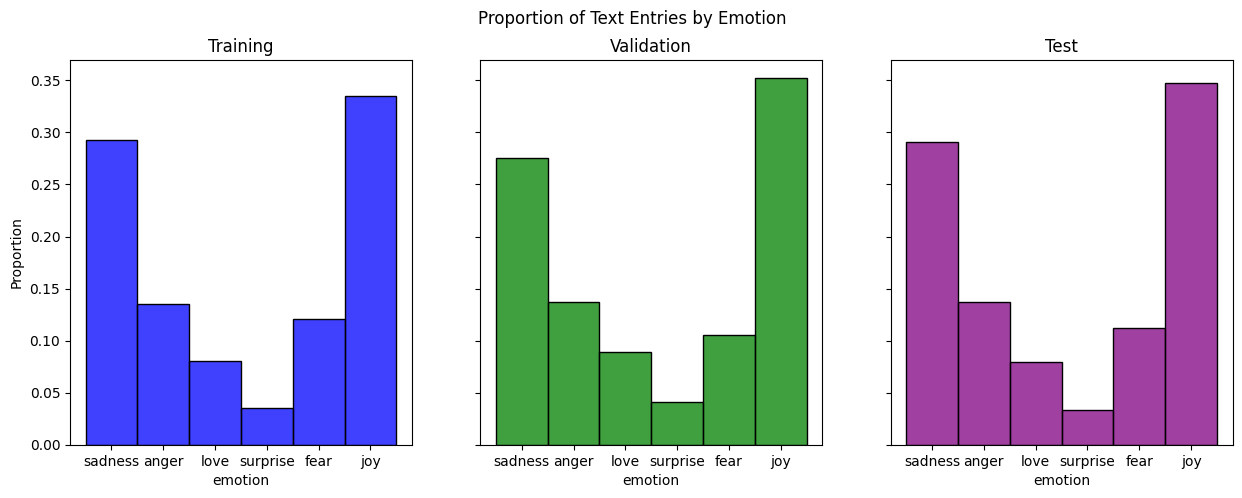

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex = True)
fig.suptitle('Proportion of Text Entries by Emotion')

# Train
sns.histplot(ax=axes[0], x=train_unique['emotion'], color = "blue", stat = "proportion")
axes[0].set_title('Training')

# Val
sns.histplot(ax=axes[1], x=val_unique['emotion'], color = "green", stat = "proportion")
axes[1].set_title('Validation')

# Test
sns.histplot(ax=axes[2], x=test_df['emotion'], color = "purple", stat = "proportion")
axes[2].set_title('Test')


Text(0, 0.5, 'Count')

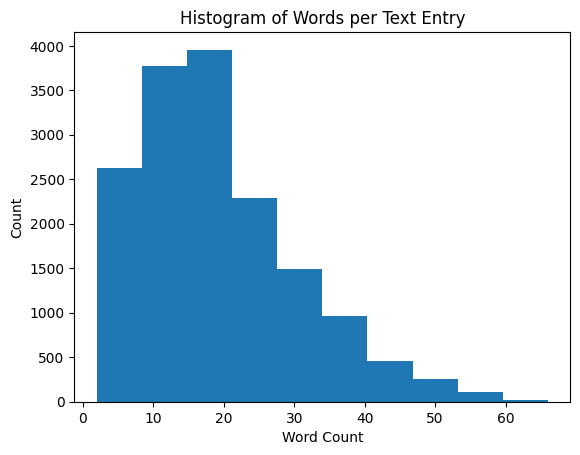

In [23]:
## How long is each text?

text_lengths = []

for txt in train_unique['text']:
    ## Split each string on whitespace
    text_words = txt.split()
    text_lengths.append(len(text_words))
    
    
plt.hist(text_lengths)
plt.title('Histogram of Words per Text Entry')
plt.xlabel('Word Count')
plt.ylabel('Count')

In [24]:
print(np.mean(text_lengths))
print(np.median(text_lengths))

19.176673567977915
17.0


Each of the texts is not overly long, with a mean length of 19 words, and a median length of 17 words.

Based on the 3-panel histogram of counts by emotion, it is very good to see that each of the datasets (training, test, and validation) all have roughly the same proportions of each emotion. However, each dataset is unbalanced across the different classes, with joy first at ~35%, and surprise last at <5%.

Becuase all three datasets have roughly equal proportions, I will first try training the model as-is, then compare the results with an oversampled training set. SMOTE (Synthetic Minority Over-sampling Technique) is an oversampling technique that artificially adds non-majority examples to the set, such that the class proportions become balanced.

Before training the model, first the text entries need to be converted to a numeric representation. I will use the Keras library built-in TextVectorization layer, which includes the 'int' output type. This method works as follows *(from Keras documentation)*: 

- Standardize each example (usually lowercasing + punctuation stripping)
- Split each example into substrings (usually words)
- Recombine substrings into tokens (usually ngrams)
- Index tokens (associate a unique int value with each token)
- Transform each example using this index into a vector of integers.

The class labels also need to be encoded into a numeric representation for the model to work.

In [52]:
## Encode all labels

encoder = LabelEncoder()

train_labels = encoder.fit_transform(train_unique['emotion'])
val_labels = encoder.transform(val_unique['emotion'])
test_labels = encoder.transform(test_df['emotion'])

encoder.classes_

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [53]:
## Figure out vocab size:

# Source: https://stackoverflow.com/a/18937309/7636462
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

15212


There are 15,212 unique words in the training dataset. This is larger than I would have guessed given that each entry has 20 words on average.

In [54]:
## Text Vectorization

## use keras text vectorization layer

vectorizer = keras.layers.TextVectorization(standardize = 'lower_and_strip_punctuation',
                                             split='whitespace',
                                            output_mode = 'int',
                                            output_sequence_length = 50,
                                           ngrams = 2)

In [55]:
# Train vectorizer
vectorizer.adapt(train_unique['text'])

## Vectorize data

train_vec = vectorizer(train_unique['text'])

val_vec = vectorizer(val_unique['text'])

test_vec = vectorizer(test_df['text'])

In [56]:
print(train_vec.shape, val_vec.shape, test_vec.shape)

(15939, 50) (1996, 50) (2000, 50)


In [57]:
vectorizer.vocabulary_size()

122473

In [58]:
## Apply SMOTE on training data, to use later

oversample = SMOTE()

train_over, train_lab_over = oversample.fit_resample(train_vec, train_labels)

In [59]:
train_over.shape

## The training data went from length 15,939 to 32,070 (or plus 16,131)

(32070, 50)

### Model Building and Training

I am going to use a Recurrent Neural Network to classify the text data into one of 6 emotions. RNN takes into account the history of the sequence, rather than analyzing each word by itself, so it should be better at performing emotional classification, where nearby words and context is quite important.

I am using a sequential model that alternates Long-Short Term Memory (LSTM) cells with Gated Recurrent Unit (GRU) cells, with dropout layers in between. The model decreases the number of recurrent units as the layers increase with the idea that the features are being fine tuned through the layers. After the final LSTM, I added a 10 unit dense layer to match the 10 unit LSTM, followed by an activity regularization layer to help with cost updates from the imbalanced data. Finally, the output layer is a 6-neuron dense layer with softmax activation to output the probability of each entry being assigned to one of 6 emotions.

In [60]:
## Set random seed for repeatability

keras.utils.set_random_seed(812)

In [61]:
## Build an RNN model

batch_size = 100
vocab_size = vectorizer.vocabulary_size()
seq_len = train_vec.shape[1]

model = keras.Sequential()

# Embed vectorized text into a dense vector, scaling down by 10x
model.add(keras.layers.Embedding(input_dim = vocab_size,  # size of dictionary
                                output_dim = 100,
                                input_length = seq_len))   # length of vec sample

# LSTM layer with 100 units
model.add(keras.layers.LSTM(50, return_sequences = True, input_shape = (batch_size, vocab_size, 100)))

model.add(keras.layers.Dropout(0.2))

# GRU layer with 50 units
model.add(keras.layers.GRU(units = 25, 
                          return_sequences = True))

model.add(keras.layers.Dropout(0.2))

# GRU layer with 10 units
model.add(keras.layers.LSTM(units = 10))

model.add(keras.layers.Dense(10, activation = 'tanh'))

model.add(keras.layers.ActivityRegularization(l1=0.1, l2=0.2))

# Dense layer with 6 nodes (for each classification)
# Softmax activation for multiclass problem
model.add(keras.layers.Dense(6, activation = 'softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           12247300  
                                                                 
 lstm_7 (LSTM)               (None, 50, 50)            30200     
                                                                 
 dropout_6 (Dropout)         (None, 50, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 50, 25)            5775      
                                                                 
 dropout_7 (Dropout)         (None, 50, 25)            0         
                                                                 
 lstm_8 (LSTM)               (None, 10)                1440      
                                                                 
 dense_6 (Dense)             (None, 10)               

In [62]:
## Compile and train

model.compile(optimizer = 'rmsprop',
              loss = keras.losses.SparseCategoricalCrossentropy(),
             metrics = ['accuracy'])

# Save weights so that I can re-run model with different tuning and compare apples-to-apples
model.save_weights('/kaggle/working/weights1.h5')

In [63]:
# Load in untouched weights
model.load_weights('/kaggle/working/weights1.h5')

hist1 = model.fit(x = train_vec,
         y = train_labels,
          batch_size = batch_size,
         validation_data = (val_vec, val_labels),
         epochs = 5)

Epoch 1/5
160/160 [==============================] - 21s 100ms/step - loss: 1.7461 - accuracy: 0.3260 - val_loss: 1.7089 - val_accuracy: 0.3106
Epoch 2/5
160/160 [==============================] - 9s 54ms/step - loss: 1.6780 - accuracy: 0.3325 - val_loss: 1.6567 - val_accuracy: 0.3522
Epoch 3/5
160/160 [==============================] - 7s 45ms/step - loss: 1.6380 - accuracy: 0.3353 - val_loss: 1.6272 - val_accuracy: 0.3522
Epoch 4/5
160/160 [==============================] - 4s 26ms/step - loss: 1.6122 - accuracy: 0.3353 - val_loss: 1.6118 - val_accuracy: 0.3522
Epoch 5/5
160/160 [==============================] - 5s 29ms/step - loss: 1.5938 - accuracy: 0.3353 - val_loss: 1.6265 - val_accuracy: 0.3522


It looks like the model is currently hovering around the maximum class proportion in the training and validation sets for the resulting accuracy. Let's try training more epochs to see what we get.

In [64]:
model.load_weights('/kaggle/working/weights1.h5')

hist2 = model.fit(x = train_vec,
         y = train_labels,
          batch_size = batch_size,
         validation_data = (val_vec, val_labels),
         epochs = 15)

Epoch 1/15
160/160 [==============================] - 2s 11ms/step - loss: 1.7481 - accuracy: 0.3212 - val_loss: 1.7115 - val_accuracy: 0.2946
Epoch 2/15
160/160 [==============================] - 2s 11ms/step - loss: 1.6792 - accuracy: 0.3301 - val_loss: 1.6583 - val_accuracy: 0.3522
Epoch 3/15
160/160 [==============================] - 2s 11ms/step - loss: 1.6386 - accuracy: 0.3353 - val_loss: 1.6278 - val_accuracy: 0.3522
Epoch 4/15
160/160 [==============================] - 2s 11ms/step - loss: 1.6124 - accuracy: 0.3353 - val_loss: 1.6150 - val_accuracy: 0.3522
Epoch 5/15
160/160 [==============================] - 2s 11ms/step - loss: 1.5850 - accuracy: 0.3359 - val_loss: 1.5542 - val_accuracy: 0.3527
Epoch 6/15
160/160 [==============================] - 4s 23ms/step - loss: 1.4099 - accuracy: 0.3885 - val_loss: 1.3981 - val_accuracy: 0.4203
Epoch 7/15
160/160 [==============================] - 3s 19ms/step - loss: 1.2927 - accuracy: 0.4488 - val_loss: 1.3997 - val_accuracy: 0.4113

Text(0.5, 1.0, 'Training and Validation Accuracies: INT VEC, RNN, RMSProp')

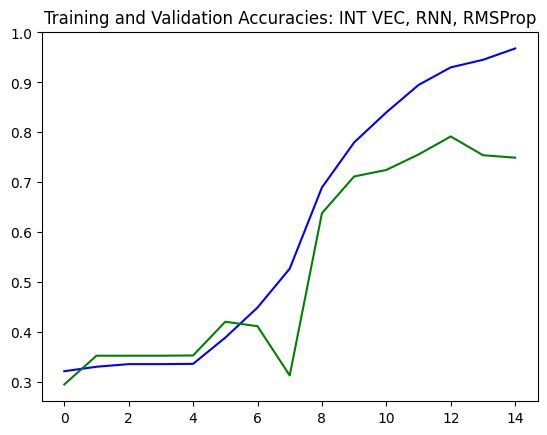

In [65]:
plt.plot(hist2.history['accuracy'], color = 'blue')
plt.plot(hist2.history['val_accuracy'], color = 'green')
plt.title('Training and Validation Accuracies: INT VEC, RNN, RMSProp')

In [66]:
## Check test accuracy
test_pred = model.predict(test_vec)

print(confusion_matrix(test_labels, np.argmax(test_pred, axis = -1)))
accuracy_score(test_labels, np.argmax(test_pred, axis = -1))

63/63 [==============================] - 1s 4ms/step
[[209  34  23   3   6   0]
 [ 37 171   0   3   5   8]
 [ 26   2 623  39   0   5]
 [  7   0  37 112   0   3]
 [107   3 140   1 330   0]
 [  7  15   2   5   0  37]]


0.741

Now I have a baseline of training results. It does appear that the model is overfitting, though due to the instability of the validation accuracy, it is hard to say whether training should be stopped at epoch 10 or 12.

As previously mentioned, I am going to see how the model performs when I use oversampled data.

In [86]:
model.load_weights('/kaggle/working/weights1.h5')

hist3 = model.fit(x = train_over,
         y = train_lab_over,
          batch_size = batch_size,
         validation_data = (val_vec, val_labels),
         epochs = 15)

Epoch 1/15
642/642 [==============================] - 15s 23ms/step - loss: 1.7942 - accuracy: 0.1651 - val_loss: 1.7932 - val_accuracy: 0.2575
Epoch 2/15
642/642 [==============================] - 9s 14ms/step - loss: 1.7928 - accuracy: 0.1674 - val_loss: 1.7909 - val_accuracy: 0.3522
Epoch 3/15
642/642 [==============================] - 8s 13ms/step - loss: 1.7926 - accuracy: 0.1656 - val_loss: 1.7965 - val_accuracy: 0.0406
Epoch 4/15
642/642 [==============================] - 8s 13ms/step - loss: 1.7926 - accuracy: 0.1652 - val_loss: 1.7928 - val_accuracy: 0.0887
Epoch 5/15
642/642 [==============================] - 7s 11ms/step - loss: 1.7925 - accuracy: 0.1606 - val_loss: 1.7896 - val_accuracy: 0.2756
Epoch 6/15
642/642 [==============================] - 8s 12ms/step - loss: 1.7925 - accuracy: 0.1644 - val_loss: 1.7930 - val_accuracy: 0.0406
Epoch 7/15
642/642 [==============================] - 7s 10ms/step - loss: 1.7925 - accuracy: 0.1658 - val_loss: 1.7926 - val_accuracy: 0.040

In [87]:
## Check test accuracy
test_over = model.predict(test_vec)

print(confusion_matrix(test_labels, np.argmax(test_over, axis = -1)))
accuracy_score(test_labels, np.argmax(test_over, axis = -1))

63/63 [==============================] - 0s 4ms/step
[[  0   0 275   0   0   0]
 [  0   0 224   0   0   0]
 [  0   0 695   0   0   0]
 [  0   0 159   0   0   0]
 [  0   0 581   0   0   0]
 [  0   0  66   0   0   0]]


0.3475

The oversampled data certainly did not work! It appears that the validation accuracy is switching back and forth between different class proportions in the set, and at the end, it has predicted all emotions to label 2. Based on this behavior, I will use the regularly sampled training data for the remainder of the tuning routine.


From the lessons, smaller batch sizes may help generalize better. In the first training iteration, the validation accuracy tops out at ~75%, while the training accuracy keeps improving. I am going to try halving the batch size and seeing if there is an improvement in the overfitting / validation accuracy.


In [68]:
model.load_weights('/kaggle/working/weights1.h5')

hist4 = model.fit(x = train_vec,
         y = train_labels,
          batch_size = 50,
         validation_data = (val_vec, val_labels),
         epochs = 15)

Epoch 1/15
319/319 [==============================] - 20s 63ms/step - loss: 1.7175 - accuracy: 0.3279 - val_loss: 1.6637 - val_accuracy: 0.3522
Epoch 2/15
319/319 [==============================] - 9s 27ms/step - loss: 1.6318 - accuracy: 0.3353 - val_loss: 1.6133 - val_accuracy: 0.3522
Epoch 3/15
319/319 [==============================] - 6s 19ms/step - loss: 1.5974 - accuracy: 0.3353 - val_loss: 1.5921 - val_accuracy: 0.3522
Epoch 4/15
319/319 [==============================] - 5s 16ms/step - loss: 1.5786 - accuracy: 0.3353 - val_loss: 1.5962 - val_accuracy: 0.3522
Epoch 5/15
319/319 [==============================] - 5s 14ms/step - loss: 1.4118 - accuracy: 0.3806 - val_loss: 1.3821 - val_accuracy: 0.4153
Epoch 6/15
319/319 [==============================] - 4s 13ms/step - loss: 1.2403 - accuracy: 0.4652 - val_loss: 1.4102 - val_accuracy: 0.4474
Epoch 7/15
319/319 [==============================] - 4s 13ms/step - loss: 1.1064 - accuracy: 0.6394 - val_loss: 1.2150 - val_accuracy: 0.620

Text(0.5, 1.0, 'Training and Validation Accuracies: INT VEC, RNN, RMSProp, Batch=50')

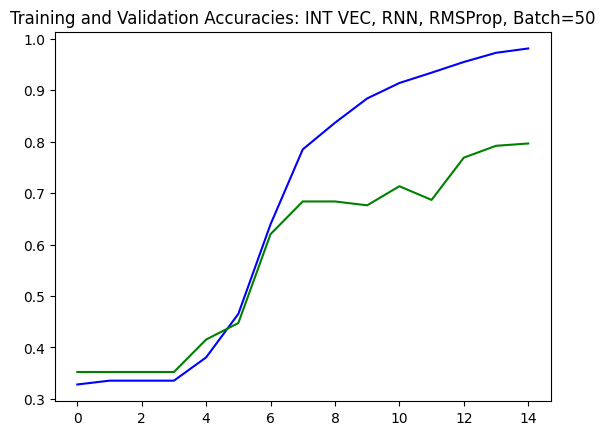

In [69]:
plt.plot(hist4.history['accuracy'], color = 'blue')
plt.plot(hist4.history['val_accuracy'], color = 'green')
plt.title('Training and Validation Accuracies: INT VEC, RNN, RMSProp, Batch=50')

It looks like decreasing the batch size had a small improvement in the overfitting, as the validation accuracy still shows an upward trajectory in epochs 12-14. Seen below, the test accuracy is also improved from 0.741 to 0.794.

In [70]:
## Check test accuracy

test_pred2 = model.predict(test_vec)

print(confusion_matrix(test_labels, np.argmax(test_pred2, axis = -1)))
accuracy_score(test_labels, np.argmax(test_pred2, axis = -1))

63/63 [==============================] - 0s 4ms/step
[[219  17  25   0  14   0]
 [ 38 168   1   5   9   3]
 [ 34  20 607  29   2   3]
 [  6  47  31  68   0   7]
 [ 38   3  27   1 512   0]
 [  4  16   3  28   1  14]]


0.794

Next, I am going to try recompiling the model with RMSProp, but this time setting momentum to 0.95. I am also going to try increasing the dropout rate to 0.3 to help with overfitting.

In [71]:
## Build an RNN model

batch_size = 50
vocab_size = vectorizer.vocabulary_size()
seq_len = train_vec.shape[1]

model2 = keras.Sequential()

# Embed vectorized text into a dense vector, scaling down by 10x
model2.add(keras.layers.Embedding(input_dim = vocab_size,  # size of dictionary
                                output_dim = 100,
                                input_length = seq_len))   # length of vec sample

# LSTM layer with 100 units
model2.add(keras.layers.LSTM(50, return_sequences = True, input_shape = (50, vocab_size, 100)))

model2.add(keras.layers.Dropout(0.3))

# GRU layer with 50 units
model2.add(keras.layers.GRU(units = 25, 
                          return_sequences = True))

model2.add(keras.layers.Dropout(0.3))

# GRU layer with 10 units
model2.add(keras.layers.LSTM(units = 10))

model2.add(keras.layers.Dense(10, activation = 'tanh'))

model2.add(keras.layers.ActivityRegularization(l1=0.1, l2=0.2))

# Dense layer with 6 nodes (for each classification)
# Softmax activation for multiclass problem
model2.add(keras.layers.Dense(6, activation = 'softmax'))

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 100)           12247300  
                                                                 
 lstm_9 (LSTM)               (None, 50, 50)            30200     
                                                                 
 dropout_8 (Dropout)         (None, 50, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50, 25)            5775      
                                                                 
 dropout_9 (Dropout)         (None, 50, 25)            0         
                                                                 
 lstm_10 (LSTM)              (None, 10)                1440      
                                                                 
 dense_8 (Dense)             (None, 10)               

In [74]:
## Compile and train

model2.compile(optimizer = keras.optimizers.RMSprop(momentum = 0.95),
              loss = keras.losses.SparseCategoricalCrossentropy(),
             metrics = ['accuracy'])

# Save weights so that I can re-run model with different tuning and compare apples-to-apples
model2.save_weights('/kaggle/working/weights2.h5')

In [75]:
model2.load_weights('/kaggle/working/weights2.h5')

hist5 = model2.fit(x = train_vec,
         y = train_labels,
          batch_size = 50,
         validation_data = (val_vec, val_labels),
         epochs = 15)

Epoch 1/15
319/319 [==============================] - 38s 104ms/step - loss: 1.5785 - accuracy: 0.3353 - val_loss: 1.5865 - val_accuracy: 0.3522
Epoch 2/15
319/319 [==============================] - 14s 43ms/step - loss: 1.5791 - accuracy: 0.3300 - val_loss: 1.5894 - val_accuracy: 0.3522
Epoch 3/15
319/319 [==============================] - 9s 28ms/step - loss: 1.5786 - accuracy: 0.3353 - val_loss: 1.5921 - val_accuracy: 0.3522
Epoch 4/15
319/319 [==============================] - 7s 21ms/step - loss: 1.5790 - accuracy: 0.3314 - val_loss: 1.5875 - val_accuracy: 0.3522
Epoch 5/15
319/319 [==============================] - 6s 18ms/step - loss: 1.5805 - accuracy: 0.3311 - val_loss: 1.5835 - val_accuracy: 0.3522
Epoch 6/15
319/319 [==============================] - 5s 16ms/step - loss: 1.5805 - accuracy: 0.3348 - val_loss: 1.5912 - val_accuracy: 0.3512
Epoch 7/15
319/319 [==============================] - 5s 16ms/step - loss: 1.5542 - accuracy: 0.3668 - val_loss: 1.5803 - val_accuracy: 0.3

Text(0.5, 1.0, 'Training and Validation Accuracies: INT VEC, RNN, RMSProp, Batch=50, Mom=0.95')

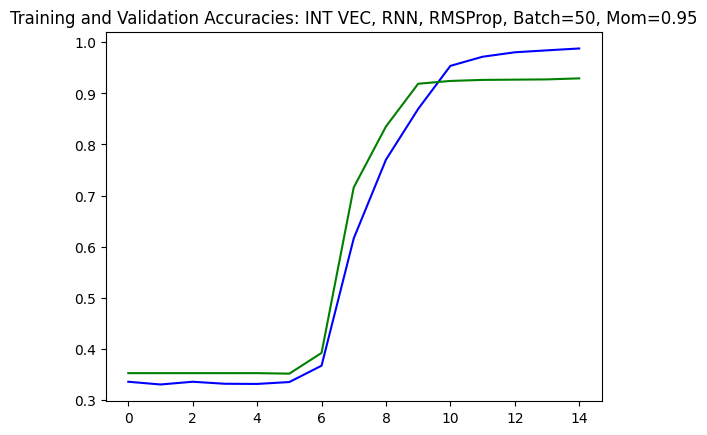

In [77]:
plt.plot(hist5.history['accuracy'], color = 'blue')
plt.plot(hist5.history['val_accuracy'], color = 'green')
plt.title('Training and Validation Accuracies: INT VEC, RNN, RMSProp, Batch=50, Mom=0.95')

In [78]:
## Check test accuracy

test_pred3 = model2.predict(test_vec)

print(confusion_matrix(test_labels, np.argmax(test_pred3, axis = -1)))
accuracy_score(test_labels, np.argmax(test_pred3, axis = -1))

63/63 [==============================] - 1s 4ms/step
[[246  15   0   0  13   1]
 [  2 194   0   0   9  19]
 [  0   9 655  23   5   3]
 [  1   0  30 126   1   1]
 [  5   5   0   0 570   1]
 [  0  10   5   0   0  51]]


0.921

The validation accuracy is much better now, capping out at about 90%. Additionally, the test accuracy is up to 92%, much improved over 79%. It looks like the number of epochs can safely be reduced to 10 based upon the plateau in the accuracy. 

Given this architecture, the tuned hyperparameters of batch size = 50, dropout = 0.3, and momentum = 0.95 gives an acceptable accuracy for the emotion classifier RNN model.

One last thing will be to try keeping the optimizer setup, but changing all the RNN cells to LSTM rather than having a mix of GRU and LSTM.

In [79]:
## Build an RNN model

batch_size = 50
vocab_size = vectorizer.vocabulary_size()
seq_len = train_vec.shape[1]

model3 = keras.Sequential()

# Embed vectorized text into a dense vector, scaling down by 10x
model3.add(keras.layers.Embedding(input_dim = vocab_size,  # size of dictionary
                                output_dim = 100,
                                input_length = seq_len))   # length of vec sample

# LSTM layer with 100 units
model3.add(keras.layers.LSTM(50, 
                             return_sequences = True, 
                             input_shape = (batch_size, vocab_size, 100)))

model3.add(keras.layers.Dropout(0.3))

# GRU layer with 50 units
model3.add(keras.layers.LSTM(units = 25, 
                          return_sequences = True))

model3.add(keras.layers.Dropout(0.3))

# GRU layer with 10 units
model3.add(keras.layers.LSTM(units = 10))

model3.add(keras.layers.Dense(10, activation = 'tanh'))

model3.add(keras.layers.ActivityRegularization(l1=0.1, l2=0.2))

# Dense layer with 6 nodes (for each classification)
# Softmax activation for multiclass problem
model3.add(keras.layers.Dense(6, activation = 'softmax'))

model3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 100)           12247300  
                                                                 
 lstm_11 (LSTM)              (None, 50, 50)            30200     
                                                                 
 dropout_10 (Dropout)        (None, 50, 50)            0         
                                                                 
 lstm_12 (LSTM)              (None, 50, 25)            7600      
                                                                 
 dropout_11 (Dropout)        (None, 50, 25)            0         
                                                                 
 lstm_13 (LSTM)              (None, 10)                1440      
                                                                 
 dense_10 (Dense)            (None, 10)               

In [80]:
## Compile and train

model3.compile(optimizer = keras.optimizers.RMSprop(momentum = 0.95),
              loss = keras.losses.SparseCategoricalCrossentropy(),
             metrics = ['accuracy'])

# Save weights so that I can re-run model with different tuning and compare apples-to-apples
model3.save_weights('/kaggle/working/weights3.h5')

In [81]:
model3.load_weights('/kaggle/working/weights3.h5')

hist6 = model3.fit(x = train_vec,
         y = train_labels,
          batch_size = 50,
         validation_data = (val_vec, val_labels),
         epochs = 15)

Epoch 1/15
319/319 [==============================] - 32s 81ms/step - loss: 1.5961 - accuracy: 0.3343 - val_loss: 1.5905 - val_accuracy: 0.3522
Epoch 2/15
319/319 [==============================] - 11s 33ms/step - loss: 1.5795 - accuracy: 0.3308 - val_loss: 1.5908 - val_accuracy: 0.3522
Epoch 3/15
319/319 [==============================] - 7s 23ms/step - loss: 1.5794 - accuracy: 0.3353 - val_loss: 1.5901 - val_accuracy: 0.3522
Epoch 4/15
319/319 [==============================] - 6s 18ms/step - loss: 1.5790 - accuracy: 0.3323 - val_loss: 1.5879 - val_accuracy: 0.3522
Epoch 5/15
319/319 [==============================] - 5s 16ms/step - loss: 1.5803 - accuracy: 0.3323 - val_loss: 1.5827 - val_accuracy: 0.3522
Epoch 6/15
319/319 [==============================] - 5s 15ms/step - loss: 1.5790 - accuracy: 0.3330 - val_loss: 1.5873 - val_accuracy: 0.3522
Epoch 7/15
319/319 [==============================] - 5s 15ms/step - loss: 1.5812 - accuracy: 0.3328 - val_loss: 1.5863 - val_accuracy: 0.35

In [88]:
## Check test accuracy

test_pred4 = model3.predict(test_vec)

print(confusion_matrix(test_labels, np.argmax(test_pred4, axis = -1)))
accuracy_score(test_labels, np.argmax(test_pred4, axis = -1))

63/63 [==============================] - 1s 4ms/step
[[  9   5 189   7  12  53]
 [  4   3 168   6   8  35]
 [ 26  16 481  21  28 123]
 [  4   0 102   3  14  36]
 [ 27   8 401  13  26 106]
 [  2   2  44   1   4  13]]


0.2675

Changing each recurrent cell to LSTM made the model take longer to converge, where the maximum training accuracy only reached 54% by epoch 15, whereas before it was over 98%.

Based on this phenomenon, I will try the reverse: switching all the recurrent cells to GRU. Will this make the model train faster?

In [83]:
## Build an RNN model

batch_size = 50
vocab_size = vectorizer.vocabulary_size()
seq_len = train_vec.shape[1]

model4 = keras.Sequential()

# Embed vectorized text into a dense vector, scaling down by 10x
model4.add(keras.layers.Embedding(input_dim = vocab_size,  # size of dictionary
                                output_dim = 100,
                                input_length = seq_len))   # length of vec sample

# LSTM layer with 100 units
model4.add(keras.layers.GRU(50, 
                             return_sequences = True, 
                             input_shape = (batch_size, vocab_size, 100)))

model4.add(keras.layers.Dropout(0.3))

# GRU layer with 50 units
model4.add(keras.layers.GRU(units = 25, 
                          return_sequences = True))

model4.add(keras.layers.Dropout(0.3))

# GRU layer with 10 units
model4.add(keras.layers.GRU(units = 10))

model4.add(keras.layers.Dense(10, activation = 'tanh'))

model4.add(keras.layers.ActivityRegularization(l1=0.1, l2=0.2))

# Dense layer with 6 nodes (for each classification)
# Softmax activation for multiclass problem
model4.add(keras.layers.Dense(6, activation = 'softmax'))

model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 50, 100)           12247300  
                                                                 
 gru_7 (GRU)                 (None, 50, 50)            22800     
                                                                 
 dropout_14 (Dropout)        (None, 50, 50)            0         
                                                                 
 gru_8 (GRU)                 (None, 50, 25)            5775      
                                                                 
 dropout_15 (Dropout)        (None, 50, 25)            0         
                                                                 
 gru_9 (GRU)                 (None, 10)                1110      
                                                                 
 dense_14 (Dense)            (None, 10)               

In [84]:
## Compile and train

model4.compile(optimizer = keras.optimizers.RMSprop(momentum = 0.95),
              loss = keras.losses.SparseCategoricalCrossentropy(),
             metrics = ['accuracy'])

# Save weights so that I can re-run model with different tuning and compare apples-to-apples
model4.save_weights('/kaggle/working/weights4.h5')

In [85]:
model4.load_weights('/kaggle/working/weights4.h5')

hist7 = model4.fit(x = train_vec,
         y = train_labels,
          batch_size = 50,
         validation_data = (val_vec, val_labels),
         epochs = 15)

Epoch 1/15
319/319 [==============================] - 31s 81ms/step - loss: 1.5971 - accuracy: 0.3350 - val_loss: 1.5876 - val_accuracy: 0.3522
Epoch 2/15
319/319 [==============================] - 11s 33ms/step - loss: 1.5787 - accuracy: 0.3314 - val_loss: 1.5894 - val_accuracy: 0.3522
Epoch 3/15
319/319 [==============================] - 7s 23ms/step - loss: 1.5792 - accuracy: 0.3353 - val_loss: 1.5877 - val_accuracy: 0.3522
Epoch 4/15
319/319 [==============================] - 6s 18ms/step - loss: 1.5793 - accuracy: 0.3323 - val_loss: 1.5890 - val_accuracy: 0.3522
Epoch 5/15
319/319 [==============================] - 5s 16ms/step - loss: 1.5796 - accuracy: 0.3328 - val_loss: 1.5824 - val_accuracy: 0.3522
Epoch 6/15
319/319 [==============================] - 5s 15ms/step - loss: 1.5793 - accuracy: 0.3325 - val_loss: 1.5824 - val_accuracy: 0.3522
Epoch 7/15
319/319 [==============================] - 4s 14ms/step - loss: 1.5810 - accuracy: 0.3333 - val_loss: 1.5871 - val_accuracy: 0.35

This model got stuck at 0.3522 validation accuracy and did not show any learning throughout the epochs. Therefore it appears that the ideal model is a mix of LSTM (long short term memory) and GRU (gated recurrent unit) cells.

In [89]:
## Final test accuracy after training best model (#4) to 10 epochs

model2.load_weights('/kaggle/working/weights2.h5')

hist_final = model2.fit(x = train_vec,
         y = train_labels,
          batch_size = 50,
         validation_data = (val_vec, val_labels),
         epochs = 10)


Epoch 1/10
319/319 [==============================] - 4s 11ms/step - loss: 1.5797 - accuracy: 0.3353 - val_loss: 1.5865 - val_accuracy: 0.3522
Epoch 2/10
319/319 [==============================] - 4s 11ms/step - loss: 1.5796 - accuracy: 0.3326 - val_loss: 1.5893 - val_accuracy: 0.3522
Epoch 3/10
319/319 [==============================] - 4s 11ms/step - loss: 1.5793 - accuracy: 0.3353 - val_loss: 1.5889 - val_accuracy: 0.3522
Epoch 4/10
319/319 [==============================] - 4s 11ms/step - loss: 1.5795 - accuracy: 0.3320 - val_loss: 1.5875 - val_accuracy: 0.3522
Epoch 5/10
319/319 [==============================] - 4s 11ms/step - loss: 1.5802 - accuracy: 0.3343 - val_loss: 1.5825 - val_accuracy: 0.3522
Epoch 6/10
319/319 [==============================] - 4s 12ms/step - loss: 1.5799 - accuracy: 0.3323 - val_loss: 1.5877 - val_accuracy: 0.3522
Epoch 7/10
319/319 [==============================] - 4s 11ms/step - loss: 1.5794 - accuracy: 0.3331 - val_loss: 1.5918 - val_accuracy: 0.3522

In [90]:
## Check test accuracy

test_pred_final = model2.predict(test_vec)

print(confusion_matrix(test_labels, np.argmax(test_pred_final, axis = -1)))
accuracy_score(test_labels, np.argmax(test_pred_final, axis = -1))

63/63 [==============================] - 0s 4ms/step
[[245  17   1   0  12   0]
 [  4 203   0   1  11   5]
 [  0   6 646  38   5   0]
 [  1   1  22 133   2   0]
 [  0  11  13   0 557   0]
 [  0  21   6   2   3  34]]


0.909

The final test accuracy after 10 epochs of training on the best RNN model is 90.9%, which is slightly below the test accuracy from 15 epochs. But given the observed overfitting in the original run, this model is more likely to be generalizable than the 15 epoch run.

Text(0.5, 1.0, 'Final Training and Validation Accuracies for the Optimized RNN Model')

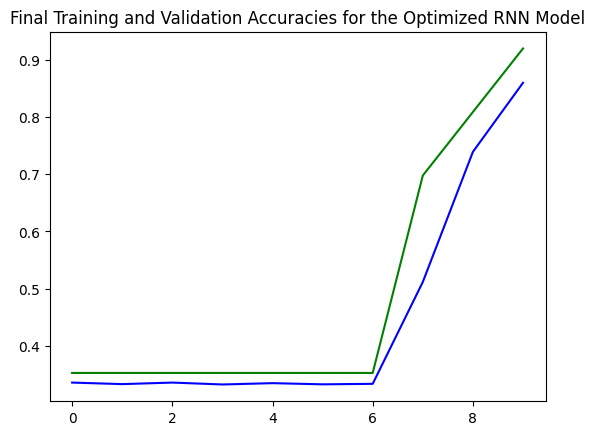

In [91]:
plt.plot(hist_final.history['accuracy'], color = 'blue')
plt.plot(hist_final.history['val_accuracy'], color = 'green')
plt.title('Final Training and Validation Accuracies for the Optimized RNN Model')

### Results and Conclusion

**Training Summary**

Overall, I found that decreasing the batch size, increasing the dropout rate, and adding momentum to the RMSProp optimizer were the most successful improvements to the training accuracy. Through these improvements, test accuracy was increased from 74.1% to 92.1% after 15 epochs of training. However, in all cases, overfitting was noted, so for the final results I re-trained the optimized model, stopping at 10 epochs, and recorded the test accuracy.

|Model Number | Architecture | Optimizer | Batch Size | Epochs | Test Accuracy |
| ----------- | --------------| --------- | ---------- | ------ | -------------- |
| 1 | LSTM(50), D/O(0.2), GRU(25), D/O(0.2), LSTM(10), Dense(10), ActReg, Dense(6) | RMSProp | 100 | 15 | 0.741 |
| 2 | Oversample: LSTM(50), D/O(0.2), GRU(25), D/O(0.2), LSTM(10), Dense(10), ActReg, Dense(6) | RMSProp | 100 | 15 | 0.348 |
| 3 | LSTM(50), D/O(0.2), GRU(25), D/O(0.2), LSTM(10), Dense(10), ActReg, Dense(6) | RMSProp | 50 | 15 | 0.794 |
| 4 | LSTM(50), D/O(0.3), GRU(25), D/O(0.3), LSTM(10), Dense(10), ActReg, Dense(6) | RMSProp, Mom = 0.95 | 50 | 15 | 0.921 |
| 5 | LSTM(50), D/O(0.3), LSTM(25), D/O(0.3), LSTM(10), Dense(10), ActReg, Dense(6) | RMSProp, Mom = 0.95 | 50 | 15 | 0.268 |
| 6 | GRU(50), D/O(0.3), GRU(25), D/O(0.3), GRU(10), Dense(10), ActReg, Dense(6) | RMSProp, Mom = 0.95 | 50 | 15 | 0.348 |
| 7 | LSTM(50), D/O(0.3), GRU(25), D/O(0.3), LSTM(10), Dense(10), ActReg, Dense(6) | RMSProp, Mom = 0.95 | 50 | 10 | 0.909 |

**Conclusion**

Deep learning algorithms, and particularly Recurrent Neural Networks, are suitable for analyzing the emotional intent behind free text data. Natural language processing must first be performed, and there are many different vectorization options to choose from. This analysis focused on integer outputs of bigrams, however other methods like Text Frequency-Inverse Document Frequency (TF-IDF) or Word2Vec vectorizers may also work. I decided to use bigrams given the contextual nature of emotional intent, as I didn't think that a single word as a feature would capture enough information.

The RNN setup was similar to prior CNN architectures, where the general idea is to have repeat layers of recurrent cells with dropout layers in between to prevent overfitting. The final output layer consists of 6 neurons with softmax activation to match the 6 emotion classes in the given dataset.

I found that the given data was imbalanced with respect to the emotion proportions, but balanced in the representation within the training, validation, and test sets. In general, balanced class counts will produce a more robust model, however in my experiment oversampling with SMOTE performed poorly. For future work, it would be interesting to see if the proportional breakdown between emotional classes reflects human nature: i.e. how often to people feel fear vs. joy and sadness vs. love? Should the dataset remain imbalanced to reflect human patterns?

The best model's architecture consisted of an embedding layer with output length = 100, then a LSTM cell with 50 units, a 30% dropout layer, a GRU cell with 25 units, a 30% dropout layer, a LSTM cell with 10 units, then a tanh activated dense layer with 10 neurons, followed by an Activity Regularizer, then finally a 6-neuron dense layer with softmax activation. It uses the RMSProp optimizer with 0.95 momentum and a batch size of 50.

This model classified the 6 emotions with 92% test accuracy after 15 epochs, and 91% accuracy after 10 epochs. In order to mitigate overfitting and output a generalizable model, 10 epochs of training are recommended.